# Waves
##### A GWDST notebook for managing the huge dataset that is all BTAU parameterized GW outputs for GWDST WACCM run. Check ../scripts/waves.py for most recent analysis!

### Input and data

In [1]:
%matplotlib inline

#from glob import glob
import numpy as np
from scipy.stats import lognorm
import pandas as pd
import xarray as xr
import xarray.ufuncs as xu
import matplotlib.pyplot as plt
import seaborn as sns
#import cartopy.crs as ccrs

from dask.distributed import Client

sns.set(context='talk', style='ticks')

In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:57242 Dashboard: http://127.0.0.1:8787,Cluster Workers: 72 Cores: 72 Memory: 135.08 GB


In [ ]:
ds = xr.open_mfdataset(sorted(glob('/glade/scratch/mcamron/archive/f.c54120.FWscHIST.f09_f09.gwdst/atm/hist/f.c54120.FWscHIST.f09_f09.gwdst.cam.h1.2002-0[6,7]*')))

ds = ds.sel(lat=slice(-20,20))

# Separate out GW flux vars and convert Pa -> mPa
#gwx = xr.Dataset({var: ds[var] for var in ds.data_vars if 'BTAUX' in var}) * 1000
#gwy = xr.Dataset({var: ds[var] for var in ds.data_vars if 'BTAUY' in var}) * 1000

Now I will read in and find the magnitude of tau from the individual directions and save it separately to have and to save time!

In [ ]:
tau = xr.Dataset({str(i): xu.sqrt(xu.square(gwx[x]) + xu.square(gwy[y])) for (i, (x,y)) in enumerate(zip(gwx.data_vars, gwy.data_vars))})

tau = xr.concat([tau[i] for i in tau.data_vars], pd.Index(np.arange(1,65), name='wave'))

tau.to_dataset().to_netcdf('/glade/scratch/mcamron/output/gwdst/tau_magnitude.nc')

Let's make sure to read that in now instead of running these calculations. Now, I want to find and compare distributions of the wave fluxes at certain near-tropopause altitudes.

In [3]:
tau = xr.open_dataset('/glade/scratch/mcamron/output/gwdst/tau_magnitude.nc', chunks={'lev': 1, 'time': 24})
tau = tau.sel(lev=slice(50, 130))
tau

<xarray.Dataset>
Dimensions:  (lat: 42, lev: 6, lon: 288, time: 1464, wave: 64)
Coordinates:
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 6.25 7.5 8.75 10.0 11.25 ...
  * lev      (lev) float64 51.68 61.52 73.75 87.82 103.3 121.5
  * lat      (lat) float64 -19.32 -18.38 -17.43 -16.49 -15.55 -14.61 -13.66 ...
  * time     (time) datetime64[ns] 2002-06-01 2002-06-01T00:59:59 ...
  * wave     (wave) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
Data variables:
    0        (wave, time, lev, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...

I need to also check a lognormal plot of the same mean and standard deviation as my data. Included!

In [4]:
tauplot = tau['0'].sel(lev=60, method='nearest')
m = tauplot.where(tauplot > 10**-4).mean(skipna=True).values
v = tauplot.where(tauplot > 10**-4).var(skipna=True).values
mu = xu.log(m / xu.sqrt(1 + v/m**2))
s = xu.sqrt(xu.log(1 + v/m**2))
scale = xu.exp(mu)

x = np.arange(0, 201, 1)

print(m, v, mu, s, scale)

0.2114044725894928 1.3585875034332275 -3.27737007408 1.85654950126 0.0377273465773


In [5]:
m2 = tauplot.where(tauplot > 10**-4).mean(skipna=True).values
v2 = tauplot.where(tauplot > 10**-4).var(skipna=True).values
mu2 = xu.log(m2 / xu.sqrt(1 + v2/m2**2))
s2 = xu.sqrt(xu.log(1 + v2/m2**2))
scale2 = xu.exp(mu2)

m3 = tauplot.where(tauplot > 10**-2).mean(skipna=True).values
v3 = tauplot.where(tauplot > 10**-2).var(skipna=True).values
mu3 = xu.log(m3 / xu.sqrt(1 + v3/m3**2))
s3 = xu.sqrt(xu.log(1 + v3/m3**2))
scale3 = xu.exp(mu3)

m4 = tauplot.where(tauplot > 1).mean(skipna=True).values
v4 = tauplot.where(tauplot > 1).var(skipna=True).values
mu4 = xu.log(m4 / xu.sqrt(1 + v4/m4**2))
s4 = xu.sqrt(xu.log(1 + v4/m4**2))
scale4 = xu.exp(mu4)

m5 = tauplot.where(tauplot > 2).mean(skipna=True).values
v5 = tauplot.where(tauplot > 2).var(skipna=True).values
mu5 = xu.log(m5 / xu.sqrt(1 + v5/m5**2))
s5 = xu.sqrt(xu.log(1 + v5/m5**2))
scale5 = xu.exp(mu5)

In [6]:
colors = sns.color_palette('Dark2', 5)
colors = colors.as_hex()

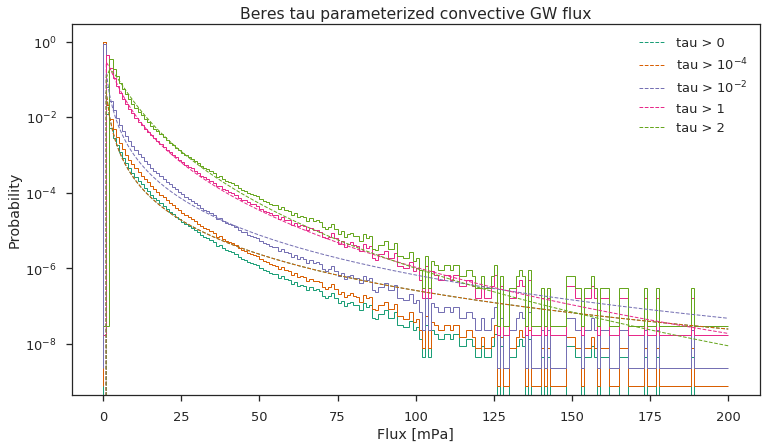

In [7]:
f, ax = plt.subplots(figsize=(11, 6.5))

(tauplot.where(tauplot > 0)
 .plot.hist(ax=ax, bins=x, density=True, log=True, histtype='step',
                linewidth=1, color=colors[0]))

(tauplot.where(tauplot > 10**-4)
 .plot.hist(ax=ax, bins=x, density=True, log=True, histtype='step',
                linewidth=1, color=colors[1]))

(tauplot.where(tauplot > 10**-2)
 .plot.hist(ax=ax, bins=x, density=True, log=True, histtype='step',
                linewidth=1, color=colors[2]))

(tauplot.where(tauplot > 1)
 .plot.hist(ax=ax, bins=x, density=True, log=True, histtype='step',
                linewidth=1, color=colors[3]))

(tauplot.where(tauplot > 2)
 .plot.hist(ax=ax, bins=x, density=True, log=True, histtype='step',
                linewidth=1, color=colors[4]))

ax.plot(x, lognorm.pdf(x, s, scale=scale), linewidth=1, c=colors[0], ls='dashed', label=('tau > 0'))
ax.plot(x, lognorm.pdf(x, s2, scale=scale2), linewidth=1, c=colors[1], ls='dashed', label=(r'tau > $10^{-4}$'))
ax.plot(x, lognorm.pdf(x, s3, scale=scale3), linewidth=1, c=colors[2], ls='dashed', label=(r'tau > $10^{-2}$'))
ax.plot(x, lognorm.pdf(x, s4, scale=scale4), linewidth=1, c=colors[3], ls='dashed', label=(r'tau > 1'))
ax.plot(x, lognorm.pdf(x, s5, scale=scale5), linewidth=1, c=colors[4], ls='dashed', label=(r'tau > 2'))

ax.legend(loc='upper right')
ax.set_xlabel('Flux [mPa]')
ax.set_ylabel('Probability')
ax.set_title('Beres tau parameterized convective GW flux')

plt.tight_layout()

f.savefig('../figures/waves/dist_flux_LN.png')

Using the above and *Vincent and Hertzog 2014* I will use the orange tau $> 10^{-2}$ distribution cutoff for more comparisons. Above plots at 61.52 hPa.

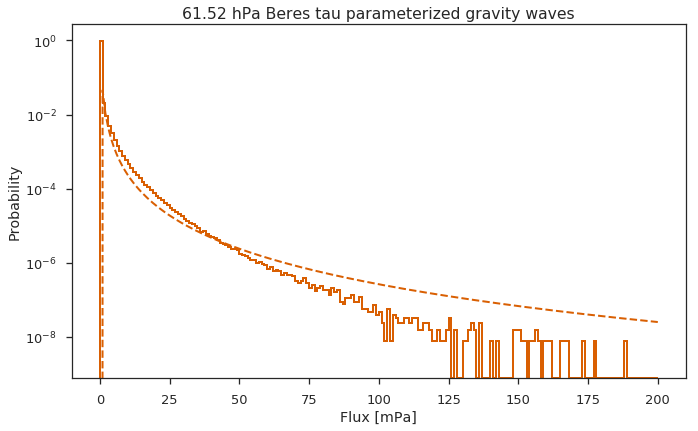

In [13]:
f, ax = plt.subplots(figsize=(11, 6.5))

(tauplot.where(tauplot > 10**-4)
 .plot.hist(ax=ax, bins=x, density=True, log=True, histtype='step', linewidth=2, color=colors[1]))

ax.plot(x, lognorm.pdf(x, s2, scale=scale2), linewidth=2, ls='dashed', color=colors[1])

ax.set_xlabel('Flux [mPa]')
ax.set_ylabel('Probability')
ax.set_title('%0.2f hPa Beres tau parameterized gravity waves' % (tauplot.lev.values))

f.savefig('../figures/waves/dist_flux.png')